In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = list(left.select_traces())
    t2 = list(right.select_traces())
    _clear_props([*t1, *t2])
    fig.add_traces(t1, rows=1, cols=1)
    fig.add_traces(t2, rows=1, cols=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [57]:
df = pd.read_csv('data/cherryBlossomMen.csv')
dogs = pd.read_csv('data/akc.csv').dropna()
sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)

b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


(ch:viz_data_design)=
# Incorporating the Data Design


When creating visualizations, it's important to also consider the data design.
How were the data collected?
Are there any special properties of the data that
we need to consider?
In this section, we'll look at a few examples of how the data design can
inform the kinds of visualizations we make.

**Using Maps for Geographic Data.**
When our dataset contains geographic information like latitudes and
longitudes, we should consider using a map instead of the typical
plots for numeric data like scatter plots.
The plot below shows the locations for US Air Quality sensors
(which are the focus of the case study in {numref}`Chapter %s <ch:pa>`).

In [4]:
def rollup_dup_sites(df):
    return (
        df.groupby('AQS_Site_ID')
        .first()
        .reset_index()
    )

def subset_aqs(df):
    subset = df[['AQS_Site_ID', 'Latitude', 'Longitude']]
    subset.columns = ['site_id', 'lat', 'lon']
    return subset

aqs_sites = (pd.read_csv('data/list_of_aqs_sites.csv')
             .pipe(rollup_dup_sites)
             .pipe(subset_aqs))
aqs_sites

,site_id,lat,lon
0,01-003-0010,30.50,-87.88
1,01-027-0001,33.28,-85.80
2,01-049-1003,34.29,-85.97
...,...,...,...
918,56-039-1013,44.37,-110.83
919,80-002-0012,32.63,-115.45
920,80-002-0014,32.63,-115.50


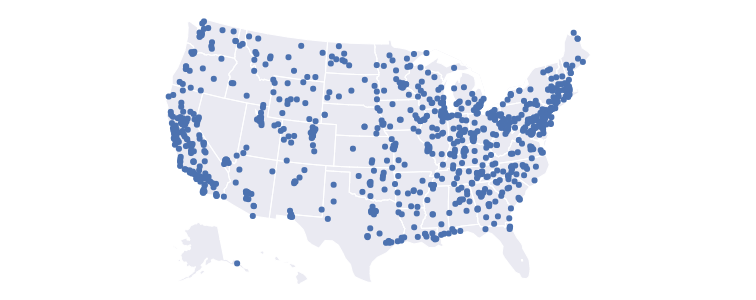

In [15]:
fig = px.scatter_geo(aqs_sites, lat='lat', lon='lon',
                     locationmode='USA-states', 
                     scope='usa',
                     width=550, height=300)
fig

Notice that there's a sensor located in Alaska, which our plotting
software correctly places below the mainland states.
A simple scatter plot that doesn't 
take the geographic projection into account wouldn't mark this point
in the right spot.


**Plotting Time-Series Data.**
When data are collected over time, it's useful to put timestamps on the x-axis.
We should also consider aggregating data into meaningful units of time.
For instance, hourly CO2 readings can be aggregated into monthly or yearly
readings to make long-term trends easier to see.

*Example: San Francisco Housing Price Percentiles.*
House prices in the US fluctuated tremendously between 2005 and 2012 as 
the US Housing Bubble caused the market to crash in 2008.
We have a dataset for home sale prices in the San Francisco area 
from April 2003 through 2008.
We've explored this data more thoroughly in {numref}`Chapter %s <ch:eda>`.
Here, we'll take a look at ways to visualize the sale prices in particular.
Since this data is a time series, we can plot the median house price over time.
Why use the median? Home prices tend to be highly skewed because of a few 
outliers.

In [21]:
def parse_dates(sfh):
    dates = pd.to_datetime(sfh['date'], infer_datetime_format=True)
    return sfh.assign(date=dates).set_index('date')

percs = [10, 30, 50, 70, 90]

def find_percentiles(series):
    prices = np.percentile(series, percs, interpolation='lower')
    return pd.Series(prices, index=percs)

monthly_percentiles = (sfh_all
 .pipe(parse_dates)
 .resample('M')
 ['price']
 .apply(find_percentiles)
 .reset_index()
 .rename(columns={'level_1': 'percentile'})
)

rel_prices = (monthly_percentiles
 .groupby('percentile')
 ['price']
 .transform(lambda s: s / s.iloc[0])
)

rel_percentiles = monthly_percentiles.assign(rel_price=rel_prices)
rel_percentiles

,date,percentile,price,rel_price
0,2003-04-30,10,255000.0,1.00
1,2003-04-30,30,340000.0,1.00
2,2003-04-30,50,421000.0,1.00
...,...,...,...,...
337,2008-11-30,50,365000.0,0.87
338,2008-11-30,70,515000.0,0.96
339,2008-11-30,90,841500.0,1.07


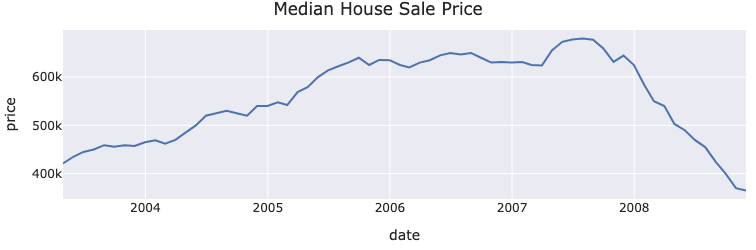

In [52]:
medians = rel_percentiles.query('percentile == 50')
fig = px.line(medians, x='date', y='price',
              title='Median House Sale Price',
              width=600, height=250)
margin(fig, t=30)

This plot shows the rise in prices before 2007 and the fall after 2008.
But we can show more information by plotting a few other percentiles instead of 
just the median. We'll draw separate lines for the 10th, 30th, 50th (median),
70th, and 90th percentile sale prices.

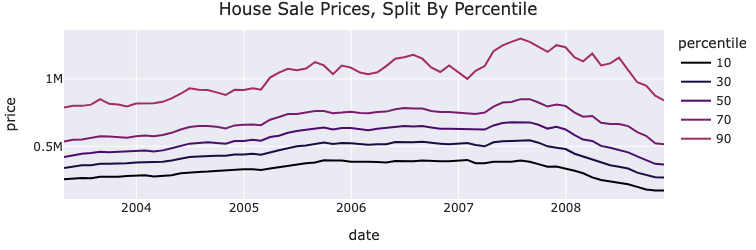

In [51]:
fig = px.line(rel_percentiles, x='date', y='price', color='percentile',
              color_discrete_sequence=plotly.express.colors.sequential.Inferno,
              title='House Sale Prices, Split By Percentile',
              width=600, height=250)
margin(fig, t=30)

Data related to money has specific things we typically need to consider,
like inflation.
Rather than plotting actual dollar amounts, let's plot the prices
relative to the starting price in 2003 for each of the percentiles.
This means that all the lines will start at y=1 in 2003, and will let us see
whether the housing crash affected homes unequally.

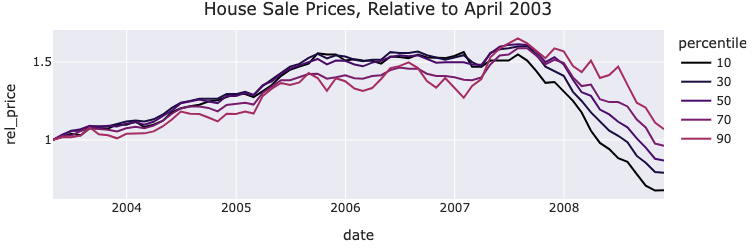

In [55]:
fig = px.line(rel_percentiles, x='date', y='rel_price', color='percentile',
              color_discrete_sequence=plotly.express.colors.sequential.Inferno,
              title='House Sale Prices, Relative to April 2003',
              width=600, height=250)
margin(fig, t=30)

The plot above shows that higher-end homes weren't as affected by the crash.
At the end of 2008, the 90th percentile home prices were nearly the same
as the 2003 prices.
But the 10th percentile home prices dropped by nearly a third.
Applying this bit of domain knowledge helps reveal subtle trends in the data
that we might otherwise miss, and
shows how we can use the data design to improve a visualization.

**Using The Sample Design.**
We should also understand whether the sample design affects our plots.
Some samples draw individuals at unequal rates.
For example, if men have been sampled at twice the rate of women,
we should avoid publishing a histogram of combined incomes until we 
adjust for the uneven gender ratio.
We need to be particularly
cautious with data that do not form a census or scientific sample.
We should also take care with cross-sectional data,
as shown in the following example.

*Example: Race Times in the Cherry Blossom Ten-Mile Run.*
Let's return to the data of Cherry Blossom race times.
Earlier in this chapter, we made this box plot of race times against runner
age.

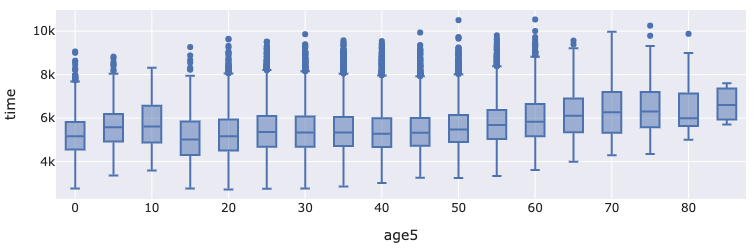

In [58]:
times = (
    df.assign(age5=df['age'] // 5 * 5)
)
px.box(times, x='age5', y='time', width=500, height=250)

It's tempting to look at this plot and say something like: a runner at age 20
can expect to have similar race times at age 40. 
However, this is a cohort study, not a longitudinal study.
For instance, the 25-year-old runners in 2001 are different people
than the 50-year-old runners
that year.
These two groups could be different in ways
that would affect the relationship between race time and age. 
For example, the 50-year-olds in the run are likely to be more fit
for their age than the 25-year-olds.
In other words, the data design doesn't let us make conclusions about
individual runners.
The visualization isn't wrong, but we should be
careful about the conclusions we draw from it.

Since each year forms a cohort, we can also make a useful plot by conditioning
on year, as shown in the plot below. Here, we've only plotted the data
for the years 1999 and 2012.

In [81]:
few = (times.query('year in [1999, 2012]')
       .groupby(['year', 'age5'])
       ['time']
       .median()
       .reset_index()
      )
few

,year,age5,time
0,1999,10.0,5289.0
1,1999,15.0,5054.0
2,1999,20.0,4643.0
...,...,...,...
29,2012,75.0,6677.5
30,2012,80.0,6081.5
31,2012,85.0,7607.0


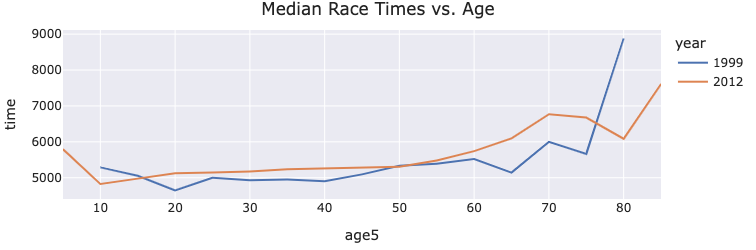

In [86]:
fig = px.line(few, x='age5', y='time', color='year',
              title='Median Race Times vs. Age',
              width=450, height=250)
margin(fig, t=30)

We see that the median race times in 2012 were higher overall than in 1999.
It's interesting that average race times have slowed over the years, which is
likely due to the increased popularity of the race and so higher participation
from novice runners in the more recent years.

## Takeaways

In this section, we explored ways to incorporate the data design into a plot.
First, we considered the type of data. Maps are useful geographic data, and
time-series plots are useful when data have a time component.
We also saw how the sampling method affects the kinds of plots we make
and the conclusions we draw. 
In the next section, we'll discuss principles for adding useful
context to plots.